# Détection OOD avec DeepBayes (Modèle DFX-D)

**Objectif** : Comparer les méthodes de détection OOD standard vs basées sur le VAE (marginal, logit, divergence)

**Structure** :
- Entraînement du modèle sur Plane/Frog
- Vérification du modèle entraîné
- Définition du protocole OOD
- Métriques standards (MSP, Entropy, Energy, Mahalanobis)
- Métriques VAE (marginal, logit, divergence)
- Évaluation comparative complète

## Setup et Imports

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf

# Désactiver l'exécution eager pour compatibilité TF 1.x
tf.compat.v1.disable_eager_execution()

print(f"TensorFlow version: {tf.__version__}")
print(f"Eager execution disabled: {not tf.executing_eagerly()}")


TensorFlow version: 2.16.1
Eager execution disabled: True


In [4]:
import numpy as np
import sys, os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm
from scipy.special import logsumexp

In [5]:
# Configuration des chemins
current_dir = os.getcwd()
paths_to_add = [
    current_dir,
    os.path.join(current_dir, 'models'),
    os.path.join(current_dir, 'alg'),
    os.path.join(current_dir, 'utils')
]

for path in paths_to_add:
    if os.path.exists(path) and path not in sys.path:
        sys.path.insert(0, path)

print("Chemins ajoutés:", paths_to_add)

Chemins ajoutés: ['c:\\Users\\perni\\code\\MVA\\deep_bayes\\DeepBayes', 'c:\\Users\\perni\\code\\MVA\\deep_bayes\\DeepBayes\\models', 'c:\\Users\\perni\\code\\MVA\\deep_bayes\\DeepBayes\\alg', 'c:\\Users\\perni\\code\\MVA\\deep_bayes\\DeepBayes\\utils']


In [6]:
from utils import load_data, save_params, load_params, init_variables
from visualisation import plot_images
from alg.vae_new import construct_optimizer

## Chargement des Données CIFAR-10

In [7]:
def to_categorical(y, num_classes=None):
    """Convertit les labels en one-hot encoding"""
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    return categorical

def load_data_cifar10(path, labels=None, conv=True, seed=0):
    """Charge les données CIFAR-10 avec possibilité de filtrer par classes"""
    def unpickle(path, name):
        f = open(path + 'cifar-10-batches-py/' + name, 'rb')
        data = pickle.load(f, encoding='latin1')
        f.close()
        return data
    
    def futz(X):
        return X.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
    
    # Charger train
    data_train = np.zeros((50000, 32, 32, 3), dtype='uint8')
    labels_train = np.zeros(50000, dtype='int32')
    fnames = ['data_batch_%i' % i for i in range(1, 6)]
    
    n_loaded = 0
    for fname in fnames:
        data = unpickle(path, fname)
        data_train[n_loaded:n_loaded + 10000] = futz(data['data'])
        labels_train[n_loaded:n_loaded + 10000] = data['labels']
        n_loaded += 10000
    
    # Charger test
    data = unpickle(path, 'test_batch')
    data_test = futz(data['data'])
    labels_test = data['labels']
    
    labels_train = to_categorical(labels_train, 10)
    labels_test = to_categorical(labels_test, 10)
    
    # Normalisation
    data_train = np.array(data_train, dtype='f') / 255.
    data_test = np.array(data_test, dtype='f') / 255.
    labels_train = np.array(labels_train, dtype='f')
    labels_test = np.array(labels_test, dtype='f')
    
    # Filtrer par classes si spécifié
    if labels is not None:
        dimY = len(labels)
        X_train, X_test = [], []
        y_train, y_test = [], []
        
        for i, label in enumerate(labels):
            y = np.zeros([1, dimY])
            y[0, i] = 1.
            
            ind_train = np.where(labels_train[:, label] == 1)[0]
            X_train.append(data_train[ind_train])
            y_train.append(np.tile(y, [len(ind_train), 1]))
            
            ind_test = np.where(labels_test[:, label] == 1)[0]
            X_test.append(data_test[ind_test])
            y_test.append(np.tile(y, [len(ind_test), 1]))
        
        X_train = np.concatenate(X_train, 0)
        y_train = np.concatenate(y_train, 0)
        X_test = np.concatenate(X_test, 0)
        y_test = np.concatenate(y_test, 0)
        
        # Shuffle
        np.random.seed(seed)
        ind = np.random.permutation(range(X_train.shape[0]))
        data_train, labels_train = X_train[ind], y_train[ind]
        ind = np.random.permutation(range(X_test.shape[0]))
        data_test, labels_test = X_test[ind], y_test[ind]
    
    return data_train, data_test, labels_train, labels_test

In [8]:
# Classes CIFAR-10
CIFAR10_CLASSES = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

print("Classes CIFAR-10 disponibles:")
for k, v in CIFAR10_CLASSES.items():
    print(f"  {k}: {v}")

Classes CIFAR-10 disponibles:
  0: airplane
  1: automobile
  2: bird
  3: cat
  4: deer
  5: dog
  6: frog
  7: horse
  8: ship
  9: truck


### Configuration

In [9]:
# Hyperparamètres
dimZ = 64 # Z = variable latente
dimH = 512 # H = couche cachée dans le MLP
n_channel = 32
batch_size = 32
lr = 1e-4
K = 10
vae_type = 'D'
input_shape = (32, 32, 3)

In [10]:
# Classes ID (In-Distribution)
ID_CLASSES = [0, 6]  # airplane, frog
print(f"Classes ID: {[CIFAR10_CLASSES[c] for c in ID_CLASSES]}")

Classes ID: ['airplane', 'frog']


In [11]:
# Charger données ID
data_path = 'cifar_data/'
X_train, X_test, Y_train, Y_test = load_data_cifar10(
    data_path, labels=ID_CLASSES, conv=True
)
dimY = Y_train.shape[1]

print(f"\nDonnées chargées:")
print(f"  Train: {X_train.shape}, Test: {X_test.shape}")
print(f"  Classes: {dimY}")


Données chargées:
  Train: (10000, 32, 32, 3), Test: (2000, 32, 32, 3)
  Classes: 2


In [12]:
# Créer validation set (20% du train)
n_val = int(0.1 * len(X_train))
X_val, Y_val = X_train[:n_val], Y_train[:n_val]
X_train, Y_train = X_train[n_val:], Y_train[n_val:]

print(f"  Train: {X_train.shape}, Val: {X_val.shape}")

  Train: (9000, 32, 32, 3), Val: (1000, 32, 32, 3)


### Visualisation des données ID

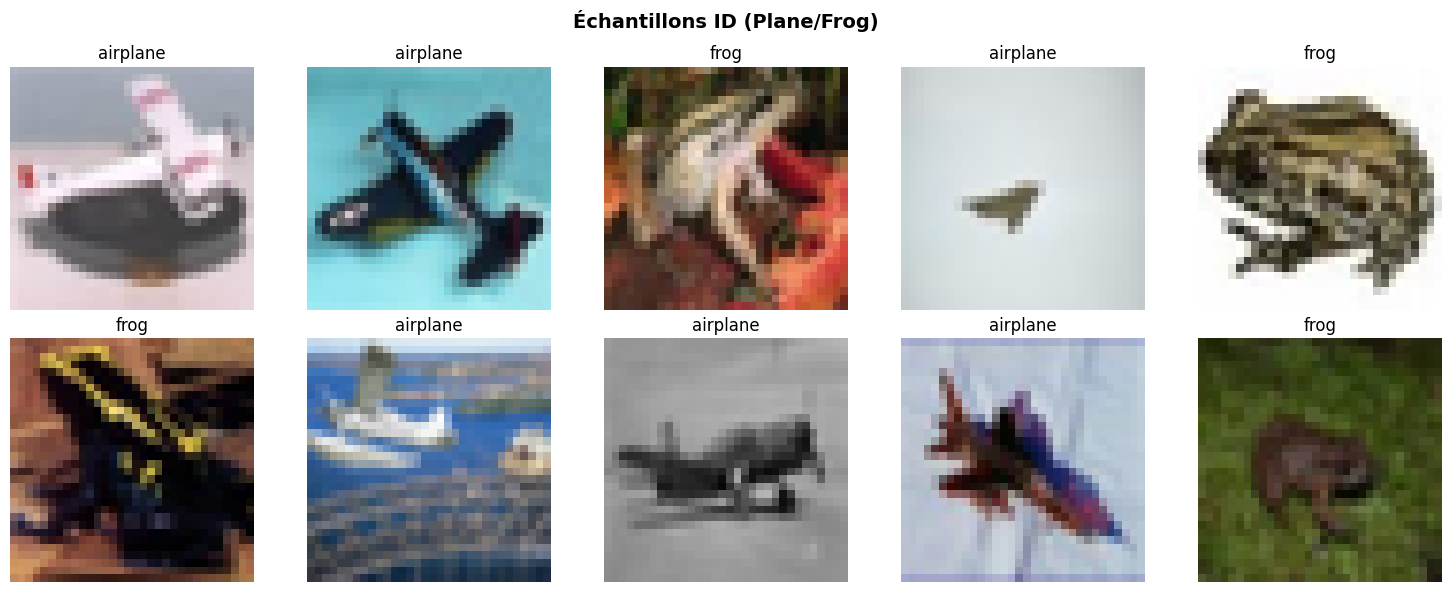

In [13]:
n_images = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(n_images):
    axes[i].imshow(X_train[i])
    class_idx = ID_CLASSES[np.argmax(Y_train[i])]
    axes[i].set_title(f'{CIFAR10_CLASSES[class_idx]}')
    axes[i].axis('off')

plt.suptitle('Échantillons ID (Plane/Frog)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 🏗️ Phase 0 : Construction et Entraînement du Modèle

In [14]:
from models.conv_generator_cifar10_D import generator
from models.conv_encoder_cifar10 import encoder_gaussian as encoder

In [15]:
# Construire le modèle
dec = generator(input_shape, dimH, dimZ, dimY, n_channel, 'sigmoid', 'gen')
enc, enc_conv, enc_mlp = encoder(input_shape, dimH, dimZ, dimY, n_channel, 'enc')

print("Modèle construit")

generator shared Conv net  network architecture: [(16, 16, 32), (8, 8, 64), (4, 4, 128)] [512]
generator shared Conv net  network architecture: [(16, 16, 32), (8, 8, 64), (4, 4, 128)] [512]
encoder shared Conv net  network architecture: [(16, 16, 32), (8, 8, 64), (4, 4, 128)] [512]
Modèle construit


In [16]:
# Compter les paramètres
def count_params_by_scope(scope_name):
    total = 0
    for var in tf.compat.v1.global_variables():
        if scope_name in var.name:
            total += np.prod(var.get_shape().as_list())
    return total

enc_params = count_params_by_scope('enc')
gen_params = count_params_by_scope('gen')
total_params = enc_params + gen_params

print(f"\nParamètres du modèle:")
print(f"  Encoder: {enc_params:,}")
print(f"  Decoder: {gen_params:,}")
print(f"  Total: {total_params:,} ({total_params/1e6:.2f}M)")


Paramètres du modèle:
  Encoder: 1,637,056
  Decoder: 3,240,194
  Total: 4,877,250 (4.88M)


In [17]:
# Définir l'optimiseur
X_ph = tf.compat.v1.placeholder(tf.float32, shape=(batch_size,) + input_shape)
Y_ph = tf.compat.v1.placeholder(tf.float32, shape=(batch_size, dimY))

ll = 'l2'
fit, eval_acc = construct_optimizer(X_ph, Y_ph, [enc_conv, enc_mlp], dec, ll, K, vae_type)
print("Optimiseur construit")


Optimiseur construit


In [18]:
# Initialiser la session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [21]:
# Chemins de sauvegarde
data_name = 'plane_frog_ood'
path_name = f'{data_name}_conv_vae_{vae_type}_{dimZ}/'
save_dir = 'save/' + path_name
os.makedirs(save_dir, exist_ok=True)
filename = save_dir + 'checkpoint'

In [22]:
# Charger ou initialiser
checkpoint = 0
try:
    load_params(sess, filename, checkpoint)
    print(f"Checkpoint {checkpoint} chargé")
except:
    print("Entraînement from scratch")
    init_variables(sess)

print(f"Sauvegardes dans: {save_dir}")

Entraînement from scratch
Sauvegardes dans: save/plane_frog_ood_conv_vae_D_64/


### Entraînement (optimisé pour CPU AMD Ryzen 5)

In [23]:
# Paramètres d'entraînement (réalistes pour CPU)
beta = 1.0
n_epochs = 50  # Nombre d'epochs total
n_iter_per_eval = 10  # Évaluer tous les 5 epochs

In [24]:
print(f"🚀 Démarrage de l'entraînement:")
print(f"  Epochs: {n_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {lr}")
print(f"  Évaluation tous les {n_iter_per_eval} epochs")

for epoch in range(0, n_epochs, n_iter_per_eval):
    print(f"\n{'='*60}")
    print(f"Epochs {epoch+1}-{epoch+n_iter_per_eval}/{n_epochs}")
    print('='*60)
    
    # Entraîner
    fit(sess, X_train, Y_train, n_iter_per_eval, lr, beta)
    
    # Évaluer
    print("\nÉvaluation:")
    eval_acc(sess, X_val, Y_val, 'validation', beta)
    eval_acc(sess, X_test, Y_test, 'test', beta)
    
    # Sauvegarder
    save_params(sess, filename, checkpoint)
    checkpoint += 1
    print(f"Checkpoint {checkpoint} sauvegardé")

print("\n" + "="*60)
print("Entraînement terminé!")
print("="*60)

🚀 Démarrage de l'entraînement:
  Epochs: 50
  Batch size: 32
  Learning rate: 0.0001
  Évaluation tous les 10 epochs

Epochs 1-10/50
training for 10 epochs with lr=0.00010, beta=1.00
Iter 1, logp(x|y)=-0.36, time=32.80
Iter 2, logp(x|y)=-0.25, time=30.44
Iter 3, logp(x|y)=-0.20, time=29.15
Iter 4, logp(x|y)=-0.17, time=29.89
Iter 5, logp(x|y)=-0.15, time=32.79
Iter 6, logp(x|y)=-0.13, time=41.12
Iter 7, logp(x|y)=-0.11, time=39.47
Iter 8, logp(x|y)=-0.10, time=31.31
Iter 9, logp(x|y)=-0.08, time=33.94
Iter 10, logp(x|y)=-0.06, time=32.48

Évaluation:
validation data approx Bayes classifier acc=93.25, bound=-0.23, time=3.00, beta=1.00
test data approx Bayes classifier acc=93.04, bound=-0.21, time=5.83, beta=1.00
parameters saved at save/plane_frog_ood_conv_vae_D_64/checkpoint_0.pkl
Checkpoint 1 sauvegardé

Epochs 11-20/50
training for 10 epochs with lr=0.00010, beta=1.00
Iter 1, logp(x|y)=-0.05, time=31.66
Iter 2, logp(x|y)=-0.04, time=32.25
Iter 3, logp(x|y)=-0.03, time=35.19
Iter 4, l

## ✅ Phase 1 : Vérification du Modèle Entraîné

### 1.1 Précision sur le test set

In [25]:
print("Évaluation finale sur le test set ID:")
eval_acc(sess, X_test, Y_test, 'test_final', beta)

Évaluation finale sur le test set ID:
test_final data approx Bayes classifier acc=95.16, bound=-0.51, time=5.82, beta=1.00


(0.9516129032258064, -0.51155361352909)

### 1.2 Visualisation des reconstructions

### 1.3 Analyse de l'espace latent

In [26]:
def get_latent_representations(sess, images, labels, batch_size=32):
    """Obtient les représentations latentes Z"""
    n_samples = len(images)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    latents = []
    for i in range(n_batches):
        start = i * batch_size
        end = min(start + batch_size, n_samples)
        batch = images[start:end]
        
        # Sauvegarder la taille réelle du batch avant padding
        actual_batch_size = len(batch)
        
        # Préparer les labels avant padding
        batch_y = np.zeros((batch_size, dimY))
        if labels is not None:
            batch_y[:actual_batch_size] = labels[start:end]
        
        # Pad les images si nécessaire
        if len(batch) < batch_size:
            padding = np.zeros((batch_size - len(batch),) + input_shape)
            batch = np.concatenate([batch, padding], axis=0)
        
        # Obtenir Z (moyenne de q(z|x))
        # 1. Appeler enc_conv pour construire le graph
        conv_out_tensor = enc_conv(X_ph)
        
        # 2. Appeler enc_mlp avec conv_out et Y_ph pour obtenir mu et log_sig
        mu, log_sig = enc_mlp(conv_out_tensor, Y_ph)
        
        # 3. Exécuter mu avec les vraies données
        z_mean = sess.run(mu, feed_dict={X_ph: batch, Y_ph: batch_y})
        
        latents.append(z_mean[:actual_batch_size])
    
    return np.concatenate(latents, axis=0)

# Obtenir représentations latentes
print("Extraction des représentations latentes...")
Z_test = get_latent_representations(sess, X_test, Y_test, batch_size)
labels_test = np.argmax(Y_test, axis=1)

print(f"Représentations latentes extraites: {Z_test.shape}")

Extraction des représentations latentes...
Représentations latentes extraites: (2000, 64)


Calcul du t-SNE (peut prendre 1-2 minutes)...


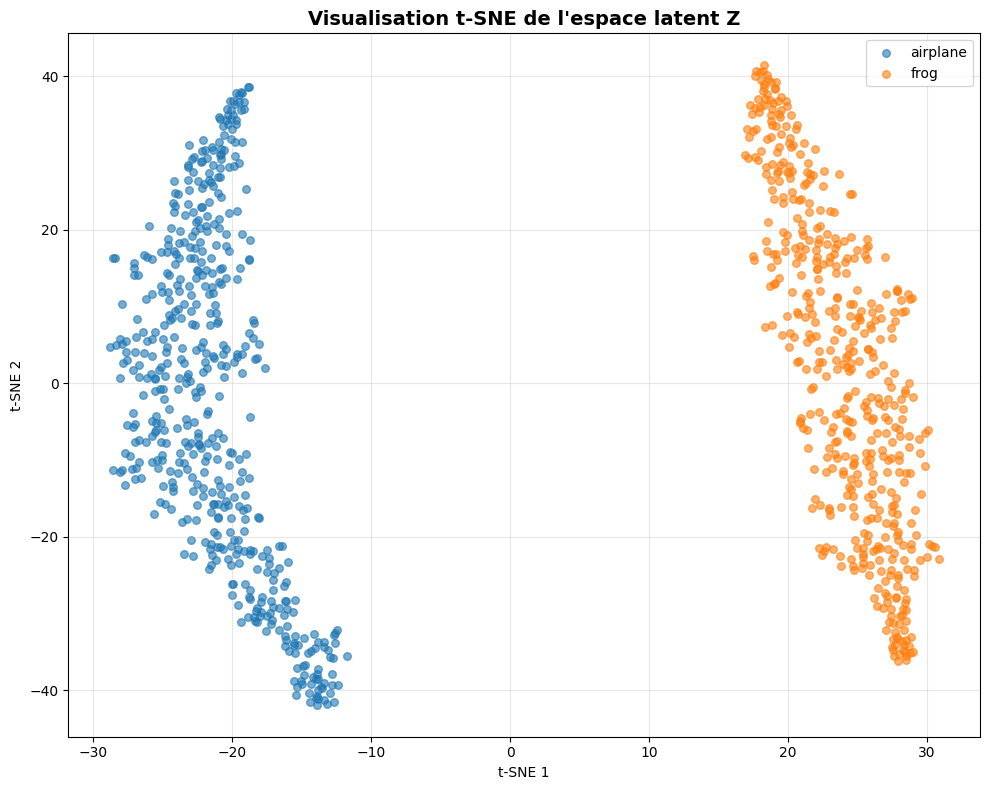

In [27]:
# Visualisation t-SNE
print("Calcul du t-SNE (peut prendre 1-2 minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
Z_tsne = tsne.fit_transform(Z_test[:1000])  # Limiter pour vitesse

plt.figure(figsize=(10, 8))
for i, class_idx in enumerate(ID_CLASSES):
    mask = labels_test[:1000] == i
    plt.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1], 
                label=CIFAR10_CLASSES[class_idx], alpha=0.6, s=30)

plt.legend()
plt.title('Visualisation t-SNE de l\'espace latent Z', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🎲 Phase 2 : Définition du Protocole OOD

In [28]:
class OODProtocol:
    """Protocole pour charger et gérer les données OOD"""
    
    def __init__(self, data_path, id_classes, seed=42):
        self.data_path = data_path
        self.id_classes = id_classes
        self.seed = seed
        self.ood_classes = [c for c in range(10) if c not in id_classes]
        
    def load_ood_data(self, ood_class, n_samples=None):
        """
        Charge les données OOD pour une classe spécifique
        
        Args:
            ood_class: Index de la classe OOD (0-9)
            n_samples: Nombre d'échantillons à charger (None = tous)
        
        Returns:
            X_ood, Y_ood
        """
        if ood_class in self.id_classes:
            raise ValueError(f"Classe {ood_class} est ID, pas OOD!")
        
        # Charger toutes les données de cette classe
        _, X_ood_full, _, Y_ood_full = load_data_cifar10(
            self.data_path, labels=[ood_class], conv=True, seed=self.seed
        )
        
        # Limiter le nombre d'échantillons si spécifié
        if n_samples is not None and n_samples < len(X_ood_full):
            indices = np.random.RandomState(self.seed).choice(
                len(X_ood_full), n_samples, replace=False
            )
            X_ood_full = X_ood_full[indices]
            Y_ood_full = Y_ood_full[indices]
        
        return X_ood_full, Y_ood_full
    
    def create_balanced_test_set(self, X_id, Y_id, ood_class):
        """
        Crée un test set équilibré ID/OOD
        
        Args:
            X_id: Images ID
            Y_id: Labels ID (one-hot avec dimY classes ID)
            ood_class: Classe OOD à utiliser
        
        Returns:
            X_test, is_ood (True si OOD)
            Note: Ne retourne pas Y car les dimensions sont incompatibles
        """
        # Charger OOD avec même nombre d'échantillons que ID
        n_id = len(X_id)
        X_ood, _ = self.load_ood_data(ood_class, n_samples=n_id)
        
        # Combiner seulement les images
        X_combined = np.concatenate([X_id, X_ood], axis=0)
        is_ood = np.concatenate([np.zeros(n_id), np.ones(len(X_ood))]).astype(bool)
        
        # Shuffle
        indices = np.random.RandomState(self.seed).permutation(len(X_combined))
        X_combined = X_combined[indices]
        is_ood = is_ood[indices]
        
        return X_combined, is_ood
    
    def get_available_ood_classes(self):
        """Retourne la liste des classes OOD disponibles"""
        return [(c, CIFAR10_CLASSES[c]) for c in self.ood_classes]

# Créer le protocole
ood_protocol = OODProtocol(data_path, ID_CLASSES)

print("Protocole OOD initialisé")
print(f"\nClasses disponibles:")
print(f"  ID: {[CIFAR10_CLASSES[c] for c in ID_CLASSES]}")
print(f"  OOD: {[name for _, name in ood_protocol.get_available_ood_classes()]}")

Protocole OOD initialisé

Classes disponibles:
  ID: ['airplane', 'frog']
  OOD: ['automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'ship', 'truck']


### Visualisation des données OOD

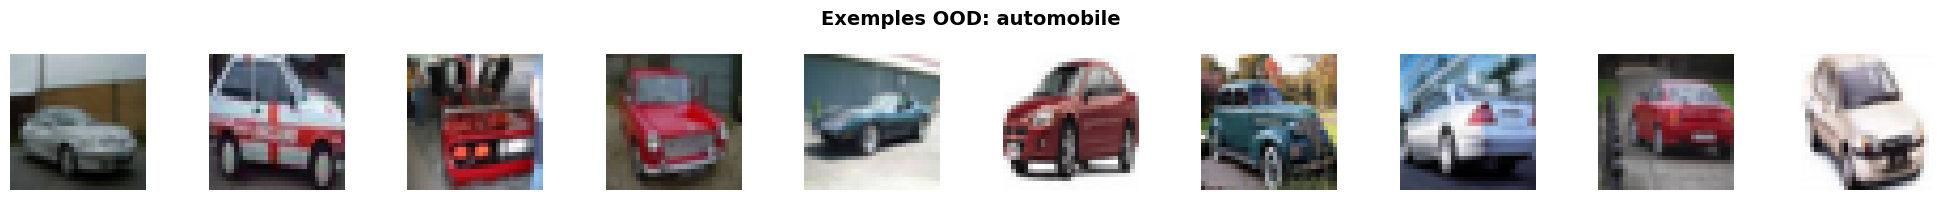

In [29]:
# Charger un exemple de classe OOD
example_ood_class = 1  # automobile
X_ood_example, Y_ood_example = ood_protocol.load_ood_data(example_ood_class, n_samples=10)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(X_ood_example[i])
    axes[i].axis('off')

plt.suptitle(f'Exemples OOD: {CIFAR10_CLASSES[example_ood_class]}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 📐 Phase 3 : Métriques Standards de Détection OOD

In [32]:
class StandardOODDetector:
    """Implémentation des métriques standard de détection OOD"""
    
    def __init__(self, sess, enc_conv, enc_mlp, dec, X_ph, Y_ph, batch_size, dimY):
        self.sess = sess
        self.enc_conv = enc_conv
        self.enc_mlp = enc_mlp
        self.dec = dec
        self.X_ph = X_ph
        self.Y_ph = Y_ph
        self.batch_size = batch_size
        self.dimY = dimY
        
        # Construire les opérations TensorFlow
        self._build_ops()
    
    def _build_ops(self):
        """Construit les opérations TensorFlow pour les scores"""
        # 1. Passer X_ph dans enc_conv
        conv_out = self.enc_conv(self.X_ph)
        
        # 2. Passer dans enc_mlp pour obtenir z_mean
        # Note: Y_ph peut être uniforme pour images test
        z_mean, z_logvar = self.enc_mlp(conv_out, self.Y_ph)
        
        # 3. UTILISER LE CLASSIFIER DU VAE (p(y|z))
        pyzx_params, pzx_params = self.dec
        self.logits = pyzx_params(z_mean, self.X_ph)  # Classifier entraîné !
        
        self.probs = tf.nn.softmax(self.logits)
        self.z_mean = z_mean
        self.z_logvar = z_logvar
        
        # Bonus: Extraire aussi p(z|x) pour autres métriques
        self.pzx_params = pzx_params
    
    def _process_batches(self, images):
        """Traite les images par batch"""
        n_samples = len(images)
        n_batches = (n_samples + self.batch_size - 1) // self.batch_size
        
        logits_list = []
        z_mean_list = []
        
        for i in range(n_batches):
            start = i * self.batch_size
            end = min(start + self.batch_size, n_samples)
            batch_x = images[start:end]
            
            actual_batch_size = len(batch_x)
            
            if len(batch_x) < self.batch_size:
                padding = np.zeros((self.batch_size - len(batch_x),) + images.shape[1:])
                batch_x = np.concatenate([batch_x, padding], axis=0)
            
            # Labels uniformes (pas de préférence de classe)
            batch_y = np.ones((self.batch_size, self.dimY)) / self.dimY
            
            # Forward pass
            logits, z_mean = self.sess.run(
                [self.logits, self.z_mean],
                feed_dict={self.X_ph: batch_x, self.Y_ph: batch_y}
            )
            
            logits_list.append(logits[:actual_batch_size])
            z_mean_list.append(z_mean[:actual_batch_size])
        
        return np.concatenate(logits_list), np.concatenate(z_mean_list)
    
    def maximum_softmax_probability(self, images):
        """
        MSP: Maximum Softmax Probability
        Score = max(softmax(logits))
        Plus le score est élevé, plus l'image est ID
        """
        logits, _ = self._process_batches(images)
        probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
        return np.max(probs, axis=1)
    
    def entropy_score(self, images):
        """
        Entropy: H(p) = -sum(p * log(p))
        Plus l'entropie est élevée, plus l'image est OOD
        (Retourne -H pour avoir des scores élevés pour ID)
        """
        logits, _ = self._process_batches(images)
        probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
        entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
        return -entropy  # Négatif pour avoir des scores élevés pour ID
    
    def energy_score(self, images):
        """
        Energy Score: E(x) = -log(sum(exp(logit_i)))
        Plus l'énergie est basse, plus l'image est ID
        (Retourne -E pour avoir des scores élevés pour ID)
        """
        logits, _ = self._process_batches(images)
        energy = -np.log(np.sum(np.exp(logits), axis=1))
        return -energy  # Négatif pour avoir des scores élevés pour ID
    
    def mahalanobis_distance(self, images, id_mean, id_cov_inv):
        """
        Mahalanobis Distance dans l'espace latent
        Distance = sqrt((z - mu)^T Sigma^-1 (z - mu))
        Plus la distance est petite, plus l'image est ID
        (Retourne -distance pour avoir des scores élevés pour ID)
        """
        _, z_mean = self._process_batches(images)
        
        # Calculer distance de Mahalanobis
        diff = z_mean - id_mean
        distance = np.sqrt(np.sum(diff @ id_cov_inv * diff, axis=1))
        return -distance  # Négatif pour avoir des scores élevés pour ID
    
    def compute_id_statistics(self, images):
        """Calcule les statistiques (mean, cov) sur les données ID"""
        _, z_mean = self._process_batches(images)
        mean = np.mean(z_mean, axis=0)
        cov = np.cov(z_mean.T)
        # Régularisation pour éviter singularité
        cov_inv = np.linalg.inv(cov + np.eye(cov.shape[0]) * 1e-6)
        return mean, cov_inv

In [33]:
# Créer le détecteur
standard_detector = StandardOODDetector(
    sess, enc_conv, enc_mlp, dec, X_ph, Y_ph, batch_size, dimY
)

# Calculer les statistiques ID pour Mahalanobis
print("Calcul des statistiques ID pour Mahalanobis...")
id_mean, id_cov_inv = standard_detector.compute_id_statistics(X_val)
print("Statistiques calculées")

Calcul des statistiques ID pour Mahalanobis...
Statistiques calculées


## 🔬 Phase 4 : Métriques VAE de Détection OOD

In [34]:
class VAEOODDetector:
    """
    Détecteur OOD basé sur les VAEs DeepBayes (DBX).
    
    Implémente les 3 méthodes de détection du papier avec calibration dynamique des seuils :
    1. Marginal Detection: -log p(x) (UNIQUEMENT pour A, B, C, F, G)
    2. Logit Detection: -log p(x, y) (UNIQUEMENT pour A, B, C, F, G)
    3. Divergence Detection: KL(p_c || p(y|x)) (pour TOUS les modèles)
    
    IMPORTANT: Les modèles D et E ne modélisent pas p(x) car ils n'ont
    pas de terme de reconstruction p(x|z). Seule Divergence Detection
    est disponible pour ces modèles.
    """
    
    def __init__(self, sess, enc_conv, enc_mlp, dec, X_ph, Y_ph, dimZ, dimY, 
                 batch_size, vae_type, ll='l2', K=10, beta=1.0):
        """
        Args:
            vae_type: 'A', 'B', 'C', 'D', 'E', 'F', 'G'
        """
        self.sess = sess
        self.enc_conv = enc_conv
        self.enc_mlp = enc_mlp
        self.dec = dec
        self.X_ph = X_ph
        self.Y_ph = Y_ph
        self.dimZ = dimZ
        self.dimY = dimY
        self.batch_size = batch_size
        self.vae_type = vae_type.upper()
        self.ll = ll
        self.K = K
        self.beta = beta
        
        # Import des fonctions de lowerbound
        from alg.lowerbound_functions import (
            lowerbound_A, lowerbound_B, lowerbound_C, 
            lowerbound_D, lowerbound_E, lowerbound_F, lowerbound_G
        )
        
        self.lowerbound_funcs = {
            'A': lowerbound_A, 'B': lowerbound_B, 'C': lowerbound_C,
            'D': lowerbound_D, 'E': lowerbound_E, 'F': lowerbound_F, 'G': lowerbound_G
        }
        
        # Classification des modèles selon leurs capacités
        self.generative_models = ['A', 'B', 'C', 'F', 'G']  # Ont p(x|z)
        self.discriminative_models = ['D', 'E']  # N'ont pas p(x|z)
        
        # Seuils calibrés (stockés après fit_thresholds)
        self.marginal_threshold = None
        self.logit_thresholds = None      # Liste de seuils par classe
        self.divergence_thresholds = None # Liste de seuils par classe
        self.divergence_mean_probs = None # Distributions moyennes par classe
        
        # Construction du graphe
        if self.vae_type in self.generative_models:
            self._build_generative_detection_graph()
        else:
            self._build_discriminative_detection_graph()
    
    def _build_generative_detection_graph(self):
        """Graphe pour modèles génératifs (A, B, C, F, G)."""
        fea = self.enc_conv(self.X_ph)
        lowerbound_func = self.lowerbound_funcs[self.vae_type]
        
        log_pxy_list = []
        for c in range(self.dimY):
            y_c = tf.one_hot(tf.ones(tf.shape(self.X_ph)[0], dtype=tf.int32) * c, depth=self.dimY)
            # ELBO = log p(x, y_c)
            bound = lowerbound_func(
                self.X_ph, fea, y_c, self.enc_mlp, self.dec, 
                self.ll, K=self.K, IS=True,
                use_mean=False, fix_samples=False, beta=self.beta
            )
            log_pxy_list.append(bound)
        
        self.log_pxy_all = tf.stack(log_pxy_list, axis=1)
        # log p(x) = logsumexp_c(log p(x, y_c))
        self.log_px = tf.reduce_logsumexp(self.log_pxy_all, axis=1)
        self.probs_y = tf.nn.softmax(self.log_pxy_all)
    
    def _build_discriminative_detection_graph(self):
        """Graphe pour modèles discriminatifs (D, E)."""
        fea = self.enc_conv(self.X_ph)
        lowerbound_func = self.lowerbound_funcs[self.vae_type]
        
        log_pxy_list = []
        for c in range(self.dimY):
            y_c = tf.one_hot(tf.ones(tf.shape(self.X_ph)[0], dtype=tf.int32) * c, depth=self.dimY)
            # Approximation discriminative
            bound = lowerbound_func(
                self.X_ph, fea, y_c, self.enc_mlp, self.dec, 
                self.ll, K=self.K, IS=True,
                use_mean=False, fix_samples=False, beta=self.beta
            )
            log_pxy_list.append(bound)
        
        self.log_pxy_all = tf.stack(log_pxy_list, axis=1)
        self.log_px = None # Pas de p(x) valide
        self.probs_y = tf.nn.softmax(self.log_pxy_all)
    
    def _compute_batch(self, images, verbose=False):
        """Exécute le graphe par batch."""
        n_samples = len(images)
        n_batches = (n_samples + self.batch_size - 1) // self.batch_size
        
        all_log_px = [] if self.vae_type in self.generative_models else None
        all_log_pxy = [] if self.vae_type in self.generative_models else None
        all_probs = []
        
        for i in range(n_batches):
            start = i * self.batch_size
            end = min(start + self.batch_size, n_samples)
            batch_x = images[start:end]
            actual_size = len(batch_x)
            
            # Padding si nécessaire
            if len(batch_x) < self.batch_size:
                padding = np.zeros((self.batch_size - len(batch_x),) + images.shape[1:])
                batch_x = np.concatenate([batch_x, padding], axis=0)
            
            if self.vae_type in self.generative_models:
                log_px, log_pxy, probs = self.sess.run(
                    [self.log_px, self.log_pxy_all, self.probs_y],
                    feed_dict={self.X_ph: batch_x}
                )
                all_log_px.append(log_px[:actual_size])
                all_log_pxy.append(log_pxy[:actual_size])
                all_probs.append(probs[:actual_size])
            else:
                probs = self.sess.run(self.probs_y, feed_dict={self.X_ph: batch_x})
                all_probs.append(probs[:actual_size])
                
            if verbose and i % 10 == 0: print(f"  Batch {i+1}/{n_batches}", end='\r')
        
        if verbose: print()
        
        if self.vae_type in self.generative_models:
            return (np.concatenate(all_log_px), np.concatenate(all_log_pxy), np.concatenate(all_probs))
        else:
            return None, None, np.concatenate(all_probs)

    def _search_alpha(self, scores, mean, std, target_fpr=0.05):
        """
        Recherche dichotomique de alpha pour atteindre le FPR cible.
        Inspiré de `detect_attacks_logp.py`.
        
        Hypothèse: Les scores sont orientés tels que `score > seuil` => OOD (rejet).
        Par exemple: scores = -log p(x) ou KL divergence.
        """
        alpha_min = 0.0
        alpha_max = 20.0 # Plage de recherche large
        alpha_now = 3.0
        
        # Fonction locale pour calculer le FPR actuel
        def get_fpr(a):
            threshold = mean + a * std
            # Rejet si score > threshold
            return np.mean(scores > threshold)
            
        current_fpr = get_fpr(alpha_now)
        
        # Recherche binaire (20 itérations suffisent généralement pour la convergence)
        for _ in range(20):
            if np.abs(current_fpr - target_fpr) < 0.001:
                break
                
            if current_fpr > target_fpr:
                # Trop de rejets (FPR trop haut) -> Il faut augmenter le seuil -> Augmenter alpha
                alpha_min = alpha_now
            else:
                # Pas assez de rejets (FPR trop bas) -> Il faut baisser le seuil -> Baisser alpha
                alpha_max = alpha_now
                
            alpha_now = 0.5 * (alpha_min + alpha_max)
            current_fpr = get_fpr(alpha_now)
            
        return alpha_now, current_fpr

    def fit_thresholds(self, X_train, Y_train, target_fpr=0.05):
        """
        Calibre les seuils de détection pour atteindre `target_fpr` sur les données d'entraînement.
        Args:
            target_fpr: Taux de faux positifs désiré (ex: 0.05 pour 5%)
        """
        print(f"📊 Calibrage des seuils (modèle {self.vae_type}) pour FPR={target_fpr:.1%}")
        
        log_px, log_pxy, probs = self._compute_batch(X_train, verbose=True)
        labels = np.argmax(Y_train, axis=1)
        
        # 1. MARGINAL DETECTION (Scores = -log p(x))
        if self.vae_type in self.generative_models:
            neg_log_px = -log_px
            mean = np.mean(neg_log_px)
            std = np.std(neg_log_px)
            
            # Recherche de l'alpha optimal
            alpha_opt, final_fpr = self._search_alpha(neg_log_px, mean, std, target_fpr)
            self.marginal_threshold = mean + alpha_opt * std
            
            print(f"✅ Marginal: α={alpha_opt:.2f}, FPR={final_fpr:.1%}, δ={self.marginal_threshold:.2f}")
        else:
            print(f"❌ Marginal: N/A pour modèle discriminatif")
            self.marginal_threshold = None
        
        # 2. LOGIT DETECTION (Scores = -log p(x|y))
        if self.vae_type in self.generative_models:
            self.logit_thresholds = []
            print(f"✅ Logit (par classe):")
            for c in range(self.dimY):
                ind = np.where(labels == c)[0]
                if len(ind) > 0:
                    neg_log_pxy_c = -log_pxy[ind, c] # Score pour la vraie classe
                    mean = np.mean(neg_log_pxy_c)
                    std = np.std(neg_log_pxy_c)
                    
                    alpha_opt, _ = self._search_alpha(neg_log_pxy_c, mean, std, target_fpr)
                    thresh = mean + alpha_opt * std
                    self.logit_thresholds.append(thresh)
                else:
                    self.logit_thresholds.append(np.inf) # Fallback
        else:
            print(f"❌ Logit: N/A pour modèle discriminatif")
            self.logit_thresholds = None
        
        # 3. DIVERGENCE DETECTION (Scores = KL)
        self.divergence_mean_probs = []
        self.divergence_thresholds = []
        print(f"✅ Divergence (par classe):")
        
        for c in range(self.dimY):
            ind = np.where(labels == c)[0]
            if len(ind) > 0:
                # Calcul de la distribution moyenne de la classe (pc)
                p_c = np.mean(probs[ind], axis=0)
                self.divergence_mean_probs.append(p_c)
                
                # Calcul des KLs sur le train set
                # KL(pc || p(y|x)) = sum pc * (log pc - log p(y|x))
                kl_values = np.sum(
                    p_c * (np.log(p_c + 1e-10) - np.log(probs[ind] + 1e-10)),
                    axis=1
                )
                
                mean = np.mean(kl_values)
                std = np.std(kl_values)
                
                alpha_opt, _ = self._search_alpha(kl_values, mean, std, target_fpr)
                thresh = mean + alpha_opt * std
                self.divergence_thresholds.append(thresh)
                print(f"   Classe {c}: mean={mean:.5f}, std={std:.5f}, α={alpha_opt:.2f}, δ={thresh:.5f}")
            else:
                self.divergence_mean_probs.append(np.ones(self.dimY)/self.dimY)
                self.divergence_thresholds.append(np.inf)
                print(f"   Classe {c}: Aucune donnée d'entraînement, seuil infini.")
                
        print("Calibrage terminé.")

    def get_rejection_mask(self, images, method='divergence'):
        """
        Retourne un masque booléen (True = Rejeté/OOD).
        Utilise les seuils pré-calibrés.
        """
        if method == 'marginal':
            if self.marginal_threshold is None:
                raise RuntimeError("Marginal detection impossible (modèle D/E ou non calibré)")
            log_px, _, _ = self._compute_batch(images)
            return (-log_px) > self.marginal_threshold
            
        elif method == 'logit':
            if self.logit_thresholds is None:
                raise RuntimeError("Logit detection impossible (modèle D/E ou non calibré)")
            _, log_pxy, probs = self._compute_batch(images)
            preds = np.argmax(probs, axis=1)
            is_rejected = np.zeros(len(images), dtype=bool)
            for i in range(len(images)):
                c = preds[i]
                score = -log_pxy[i, c]
                is_rejected[i] = score > self.logit_thresholds[c]
            return is_rejected
            
        elif method == 'divergence':
            if self.divergence_thresholds is None:
                raise RuntimeError("Non calibré")
            _, _, probs = self._compute_batch(images)
            preds = np.argmax(probs, axis=1)
            is_rejected = np.zeros(len(images), dtype=bool)
            for i in range(len(images)):
                c = preds[i]
                p_c = self.divergence_mean_probs[c]
                kl = np.sum(p_c * (np.log(p_c + 1e-10) - np.log(probs[i] + 1e-10)))
                is_rejected[i] = kl > self.divergence_thresholds[c]
            return is_rejected
        else:
            raise ValueError(f"Méthode inconnue: {method}")

    # Méthodes wrappers pour compatibilité avec l'interface précédente si besoin
    # (Elles retournent les scores bruts, pas les décisions booléennes)
    
    def marginal_detection(self, images):
        """Retourne les scores bruts log p(x)."""
        if self.vae_type in self.discriminative_models:
            raise NotImplementedError("Pas de marginal detection pour ce modèle.")
        log_px, _, _ = self._compute_batch(images)
        return log_px

    def logit_detection(self, images):
        """Retourne les scores bruts log p(x, y_pred)."""
        if self.vae_type in self.discriminative_models:
            raise NotImplementedError("Pas de logit detection pour ce modèle.")
        _, log_pxy, probs = self._compute_batch(images)
        preds = np.argmax(probs, axis=1)
        return log_pxy[np.arange(len(images)), preds]

    def divergence_detection(self, images):
        """Retourne les scores KL inversés (négatifs pour que 'haut' soit ID)."""
        if self.divergence_mean_probs is None:
            raise RuntimeError("Non calibré")
        _, _, probs = self._compute_batch(images)
        preds = np.argmax(probs, axis=1)
        scores = []
        for i in range(len(images)):
            c = preds[i]
            p_c = self.divergence_mean_probs[c]
            kl = np.sum(p_c * (np.log(p_c + 1e-10) - np.log(probs[i] + 1e-10)))
            scores.append(-kl) # Négatif car get_rejection_mask utilise KL > seuil
        return np.array(scores)

In [35]:
# Créer le détecteur
vae_detector = VAEOODDetector(
    sess, enc_conv, enc_mlp, dec, 
    X_ph, Y_ph, dimZ, dimY, batch_size,
    vae_type=vae_type,
    ll=ll,
    K=K,
    beta=beta
)

In [36]:
# Calibrer les seuils sur les données d'entraînement
vae_detector.fit_thresholds(X_train, Y_train, target_fpr=0.05)

📊 Calibrage des seuils (modèle D) pour FPR=5.0%
  Batch 281/282
❌ Marginal: N/A pour modèle discriminatif
❌ Logit: N/A pour modèle discriminatif
✅ Divergence (par classe):
   Classe 0: mean=0.00001, std=0.00001, α=0.10, δ=0.00001
   Classe 1: mean=0.00001, std=0.00000, α=0.15, δ=0.00001
Calibrage terminé.


Evaluation du gap entre ID et OOD

🔬 Analyse du gap ID vs OOD
   ID: ['airplane', 'frog']
   OOD: automobile

Divergence:
  ID:   μ=   -0.00, σ=  0.04
  OOD:  μ=   -0.02, σ=  0.08
  Gap:      0.02
  SNR:      0.20  ❌ Très faible
  Overlap: 50.0%

MSP:
  ID:   μ=    1.00, σ=  0.03
  OOD:  μ=    0.98, σ=  0.07
  Gap:      0.01
  SNR:      0.20  ❌ Très faible
  Overlap: 8.6%

Energy:
  ID:   μ=   16.82, σ=  8.00
  OOD:  μ=   10.84, σ=  7.24
  Gap:      5.98
  SNR:      0.75  ❌ Très faible
  Overlap: 50.0%


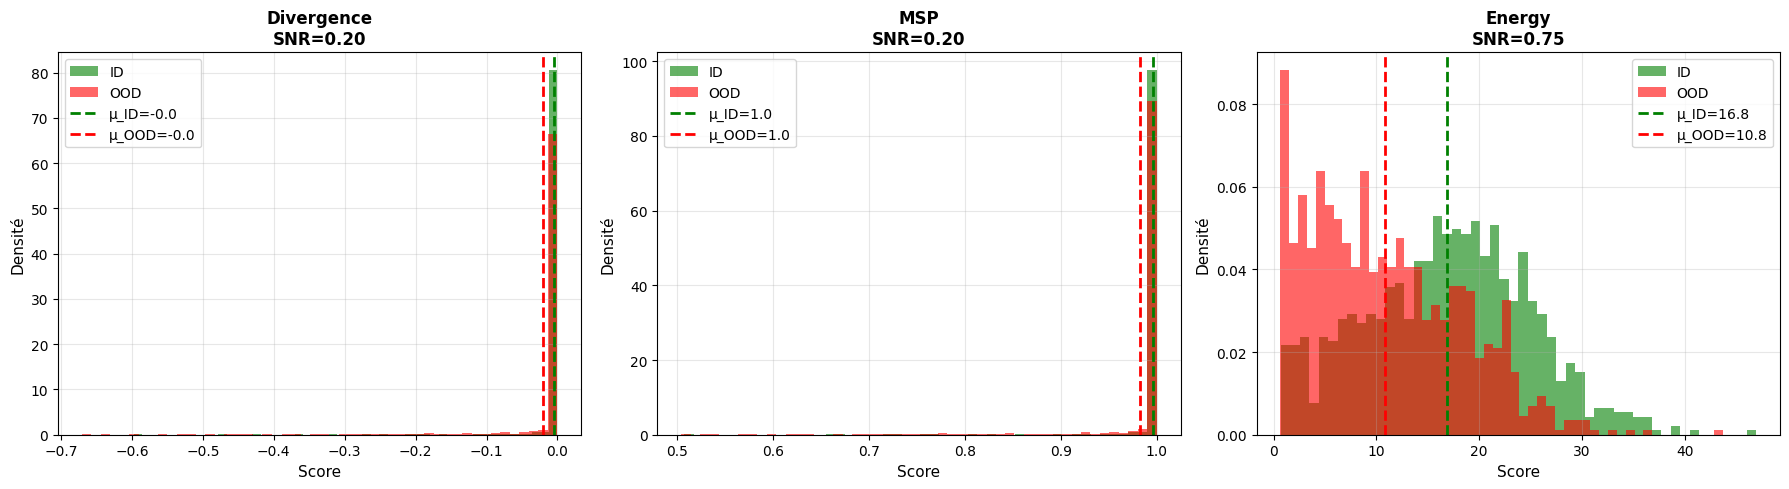


📊 Interprétation du SNR (Signal-to-Noise Ratio):
  SNR > 3:   ✅ Excellent - K=1 largement suffisant
  SNR 1-3:   ⚠️  Correct  - K=1 acceptable, K=5 pour plus de précision
  SNR < 1:   ❌ Faible   - Considérer K=5-10


In [37]:
# Choisir une classe OOD pour l'analyse
OOD_CLASS_ANALYSIS = 1  # automobile

# Charger données
X_ood_analysis, _ = ood_protocol.load_ood_data(OOD_CLASS_ANALYSIS, n_samples=len(X_test))

print(f"🔬 Analyse du gap ID vs OOD")
print(f"   ID: {[CIFAR10_CLASSES[c] for c in ID_CLASSES]}")
print(f"   OOD: {CIFAR10_CLASSES[OOD_CLASS_ANALYSIS]}")
print("="*60)

# Calculer les scores avec chaque méthode
methods_to_analyze = {
    'Divergence': vae_detector.divergence_detection,
    'MSP': standard_detector.maximum_softmax_probability,
    'Energy': standard_detector.energy_score,
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (method_name, score_func) in enumerate(methods_to_analyze.items()):
    # Calculer scores
    scores_id = score_func(X_test[:1000])  # Limiter pour vitesse
    scores_ood = score_func(X_ood_analysis[:1000])
    
    # Statistiques
    mean_id = np.mean(scores_id)
    std_id = np.std(scores_id)
    mean_ood = np.mean(scores_ood)
    std_ood = np.std(scores_ood)
    
    # Gap et SNR
    gap = abs(mean_id - mean_ood)
    noise = max(std_id, std_ood)
    snr = gap / noise if noise > 0 else float('inf')
    
    # Overlap (approximation)
    # Proportion de ID qui se chevauchent avec OOD
    overlap_threshold = min(scores_id.max(), scores_ood.max())
    overlap_id = np.sum(scores_id < overlap_threshold) / len(scores_id)
    overlap_ood = np.sum(scores_ood > overlap_threshold) / len(scores_ood)
    
    # Afficher
    print(f"\n{method_name}:")
    print(f"  ID:   μ={mean_id:8.2f}, σ={std_id:6.2f}")
    print(f"  OOD:  μ={mean_ood:8.2f}, σ={std_ood:6.2f}")
    print(f"  Gap:  {gap:8.2f}")
    print(f"  SNR:  {snr:8.2f}  {'✅ Excellent' if snr > 3 else '⚠️ Faible' if snr > 1 else '❌ Très faible'}")
    print(f"  Overlap: {(overlap_id + overlap_ood)/2*100:.1f}%")
    
    # Visualisation
    ax = axes[idx]
    ax.hist(scores_id, bins=50, alpha=0.6, label='ID', color='green', density=True)
    ax.hist(scores_ood, bins=50, alpha=0.6, label='OOD', color='red', density=True)
    ax.axvline(mean_id, color='green', linestyle='--', linewidth=2, label=f'μ_ID={mean_id:.1f}')
    ax.axvline(mean_ood, color='red', linestyle='--', linewidth=2, label=f'μ_OOD={mean_ood:.1f}')
    ax.set_xlabel('Score', fontsize=11)
    ax.set_ylabel('Densité', fontsize=11)
    ax.set_title(f'{method_name}\nSNR={snr:.2f}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 Interprétation du SNR (Signal-to-Noise Ratio):")
print("  SNR > 3:   ✅ Excellent - K=1 largement suffisant")
print("  SNR 1-3:   ⚠️  Correct  - K=1 acceptable, K=5 pour plus de précision")
print("  SNR < 1:   ❌ Faible   - Considérer K=5-10")
print("="*60)

## 📊 Phase 5 : Protocole d'Évaluation Complet

In [38]:
class OODEvaluator:
    """Classe pour évaluer les méthodes de détection OOD"""
    
    def __init__(self):
        self.methods = {}
        self.results = {}
    
    def register_method(self, name, score_func):
        """Enregistre une méthode de détection"""
        self.methods[name] = score_func
    
    def compute_metrics(self, scores_id, scores_ood):
        """
        Calcule les métriques d'évaluation
        
        Args:
            scores_id: Scores sur données ID (plus élevé = plus ID)
            scores_ood: Scores sur données OOD
        
        Returns:
            dict avec AUROC, AUPR, FPR@95
        """
        # Labels: 1 = ID, 0 = OOD
        y_true = np.concatenate([
            np.ones(len(scores_id)),
            np.zeros(len(scores_ood))
        ])
        y_scores = np.concatenate([scores_id, scores_ood])
        
        # AUROC
        auroc = roc_auc_score(y_true, y_scores)
        
        # AUPR
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        aupr = auc(recall, precision)
        
        # FPR@95 (False Positive Rate at 95% True Positive Rate)
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        idx_95 = np.argmin(np.abs(tpr - 0.95))
        fpr_at_95 = fpr[idx_95]
        
        # Detection Accuracy at optimal threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        y_pred = (y_scores >= optimal_threshold).astype(int)
        detection_acc = np.mean(y_pred == y_true)
        
        return {
            'AUROC': auroc,
            'AUPR': aupr,
            'FPR@95': fpr_at_95,
            'Detection_Acc': detection_acc,
            'Optimal_Threshold': optimal_threshold
        }
    
    def evaluate_all_methods(self, X_id, X_ood, verbose=True):
        """Évalue toutes les méthodes enregistrées"""
        results = {}
        
        for method_name, score_func in self.methods.items():
            if verbose:
                print(f"\n{'='*60}")
                print(f"Évaluation: {method_name}")
                print('='*60)
            
            # Calculer scores
            scores_id = score_func(X_id)
            scores_ood = score_func(X_ood)
            
            # Calculer métriques
            metrics = self.compute_metrics(scores_id, scores_ood)
            results[method_name] = metrics
            
            if verbose:
                print(f"  AUROC:         {metrics['AUROC']:.4f}")
                print(f"  AUPR:          {metrics['AUPR']:.4f}")
                print(f"  FPR@95:        {metrics['FPR@95']:.4f}")
                print(f"  Detection Acc: {metrics['Detection_Acc']:.4f}")
        
        self.results = results
        return results
    
    def plot_roc_curves(self, X_id, X_ood):
        """Trace les courbes ROC pour toutes les méthodes"""
        plt.figure(figsize=(10, 8))
        
        for method_name, score_func in self.methods.items():
            scores_id = score_func(X_id)
            scores_ood = score_func(X_ood)
            
            y_true = np.concatenate([
                np.ones(len(scores_id)),
                np.zeros(len(scores_ood))
            ])
            y_scores = np.concatenate([scores_id, scores_ood])
            
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            auroc = roc_auc_score(y_true, y_scores)
            
            plt.plot(fpr, tpr, label=f'{method_name} (AUROC={auroc:.3f})', linewidth=2)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Courbes ROC - Détection OOD', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_comparison_table(self):
        """Affiche un tableau comparatif des résultats"""
        if not self.results:
            print("Aucun résultat à afficher. Exécuter evaluate_all_methods d'abord.")
            return
        
        # Créer DataFrame
        import pandas as pd
        df = pd.DataFrame(self.results).T
        df = df[['AUROC', 'AUPR', 'FPR@95', 'Detection_Acc']]
        
        # Formater
        df['AUROC'] = df['AUROC'].apply(lambda x: f'{x:.4f}')
        df['AUPR'] = df['AUPR'].apply(lambda x: f'{x:.4f}')
        df['FPR@95'] = df['FPR@95'].apply(lambda x: f'{x:.4f}')
        df['Detection_Acc'] = df['Detection_Acc'].apply(lambda x: f'{x:.4f}')
        
        print("\n" + "="*80)
        print("📊 TABLEAU COMPARATIF DES MÉTHODES DE DÉTECTION OOD")
        print("="*80)
        print(df.to_string())
        print("="*80)
        
        return df

print("✅ OODEvaluator créé")

✅ OODEvaluator créé


### Évaluation sur une classe OOD

In [39]:
# Choisir une classe OOD pour l'évaluation
OOD_CLASS = 1  # automobile (différent de plane/frog)

print(f"🎯 Évaluation avec classe OOD: {CIFAR10_CLASSES[OOD_CLASS]}")
print(f"   Classes ID: {[CIFAR10_CLASSES[c] for c in ID_CLASSES]}")

# Créer le test set équilibré (sans Y car dimensions incompatibles)
X_test_balanced, is_ood = ood_protocol.create_balanced_test_set(
    X_test, Y_test, OOD_CLASS
)

X_id_eval = X_test_balanced[~is_ood]
X_ood_eval = X_test_balanced[is_ood]

print(f"\n📊 Test set créé:")
print(f"   ID samples:  {len(X_id_eval)}")
print(f"   OOD samples: {len(X_ood_eval)}")

🎯 Évaluation avec classe OOD: automobile
   Classes ID: ['airplane', 'frog']

📊 Test set créé:
   ID samples:  2000
   OOD samples: 1000


In [40]:
# Créer l'évaluateur (comme avant)
evaluator = OODEvaluator()

# Méthodes standard (utilisant le classifier du VAE)
evaluator.register_method(
    'MSP (Max Softmax Prob)',
    standard_detector.maximum_softmax_probability
)
evaluator.register_method(
    'Entropy',
    standard_detector.entropy_score
)
evaluator.register_method(
    'Energy Score',
    standard_detector.energy_score
)
evaluator.register_method(
    'Mahalanobis',
    lambda x: standard_detector.mahalanobis_distance(x, id_mean, id_cov_inv)
)

# Méthodes VAE - Uniquement celles disponibles pour votre modèle
if vae_type in ['A', 'B', 'C', 'F', 'G']:
    # Modèles génératifs : toutes les méthodes disponibles
    evaluator.register_method(
        'VAE Marginal (log p(x))',
        vae_detector.marginal_detection
    )
    evaluator.register_method(
        'VAE Logit (log p(x,y))',
        vae_detector.logit_detection
    )
    evaluator.register_method(
        'VAE Divergence (KL)',
        vae_detector.divergence_detection
    )
else:
    # Modèles D et E : uniquement Divergence
    print(f"⚠️  Modèle {vae_type}: Seule Divergence Detection disponible")
    evaluator.register_method(
        'VAE Divergence (KL)',
        vae_detector.divergence_detection
    )

print("✅ Toutes les méthodes enregistrées")

⚠️  Modèle D: Seule Divergence Detection disponible
✅ Toutes les méthodes enregistrées


In [41]:
# Évaluer toutes les méthodes
print("\n" + "="*80)
print(f"🚀 ÉVALUATION COMPLÈTE - OOD: {CIFAR10_CLASSES[OOD_CLASS]}")
print("="*80)

results = evaluator.evaluate_all_methods(X_id_eval, X_ood_eval, verbose=True)

print("\n✅ Évaluation terminée")


🚀 ÉVALUATION COMPLÈTE - OOD: automobile

Évaluation: MSP (Max Softmax Prob)
  AUROC:         0.6363
  AUPR:          0.8460
  FPR@95:        0.8480
  Detection Acc: 0.7050

Évaluation: Entropy
  AUROC:         0.7186
  AUPR:          0.8245
  FPR@95:        0.8480
  Detection Acc: 0.6720

Évaluation: Energy Score
  AUROC:         0.7161
  AUPR:          0.8224
  FPR@95:        0.8480
  Detection Acc: 0.6683

Évaluation: Mahalanobis
  AUROC:         0.5330
  AUPR:          0.7067
  FPR@95:        0.9820
  Detection Acc: 0.5280

Évaluation: VAE Divergence (KL)
  AUROC:         0.5828
  AUPR:          0.6860
  FPR@95:        0.8490
  Detection Acc: 0.5693

✅ Évaluation terminée


In [42]:
# Afficher le tableau comparatif
df_results = evaluator.plot_comparison_table()


📊 TABLEAU COMPARATIF DES MÉTHODES DE DÉTECTION OOD
                         AUROC    AUPR  FPR@95 Detection_Acc
MSP (Max Softmax Prob)  0.6363  0.8460  0.8480        0.7050
Entropy                 0.7186  0.8245  0.8480        0.6720
Energy Score            0.7161  0.8224  0.8480        0.6683
Mahalanobis             0.5330  0.7067  0.9820        0.5280
VAE Divergence (KL)     0.5828  0.6860  0.8490        0.5693


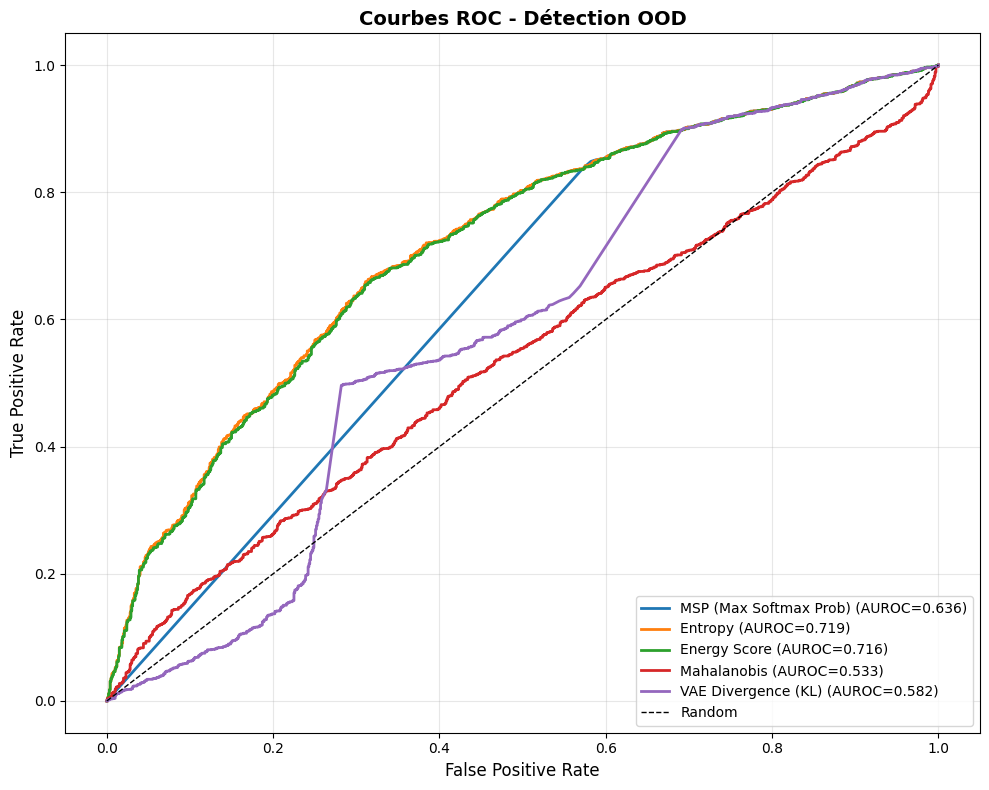

In [43]:
# Tracer les courbes ROC
evaluator.plot_roc_curves(X_id_eval, X_ood_eval)

### Évaluation sur toutes les classes OOD

In [44]:
# Évaluer sur toutes les classes OOD disponibles
all_results = {}

for ood_class, ood_name in ood_protocol.get_available_ood_classes():
    print(f"\n{'='*80}")
    print(f"📊 Évaluation OOD: {ood_name} (classe {ood_class})")
    print('='*80)
    
    # Créer test set (sans Y)
    X_test_bal, is_ood = ood_protocol.create_balanced_test_set(
        X_test, Y_test, ood_class
    )
    X_id_eval = X_test_bal[~is_ood]
    X_ood_eval = X_test_bal[is_ood]
    
    # Évaluer
    results = evaluator.evaluate_all_methods(X_id_eval, X_ood_eval, verbose=False)
    all_results[ood_name] = results
    
    # Afficher meilleure méthode
    best_method = max(results.items(), key=lambda x: x[1]['AUROC'])
    print(f"  ✅ Meilleure méthode: {best_method[0]}")
    print(f"     AUROC: {best_method[1]['AUROC']:.4f}")

print("\n" + "="*80)
print("✅ Évaluation complète terminée")
print("="*80)


📊 Évaluation OOD: automobile (classe 1)
  ✅ Meilleure méthode: Entropy
     AUROC: 0.7186

📊 Évaluation OOD: bird (classe 2)
  ✅ Meilleure méthode: Energy Score
     AUROC: 0.7535

📊 Évaluation OOD: cat (classe 3)
  ✅ Meilleure méthode: Energy Score
     AUROC: 0.7453

📊 Évaluation OOD: deer (classe 4)
  ✅ Meilleure méthode: Energy Score
     AUROC: 0.7820

📊 Évaluation OOD: dog (classe 5)
  ✅ Meilleure méthode: Energy Score
     AUROC: 0.7531

📊 Évaluation OOD: horse (classe 7)
  ✅ Meilleure méthode: Entropy
     AUROC: 0.7747

📊 Évaluation OOD: ship (classe 8)
  ✅ Meilleure méthode: VAE Divergence (KL)
     AUROC: 0.6224

📊 Évaluation OOD: truck (classe 9)
  ✅ Meilleure méthode: Entropy
     AUROC: 0.7122

✅ Évaluation complète terminée


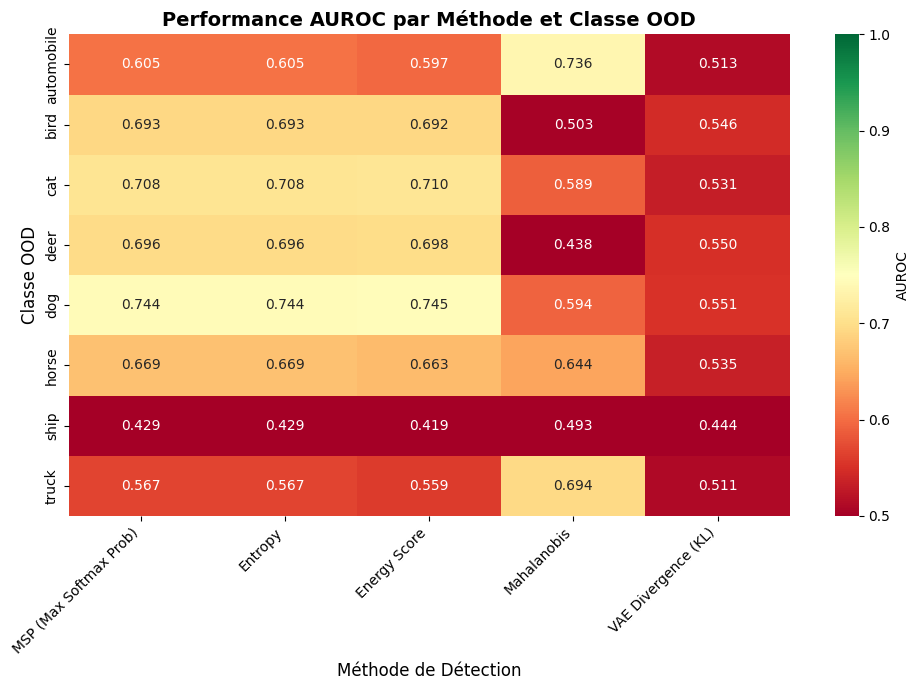


📊 Performance moyenne (AUROC) par méthode:
MSP (Max Softmax Prob)        : 0.6388 ± 0.1024
Entropy                       : 0.6388 ± 0.1024
Energy Score                  : 0.6353 ± 0.1066
Mahalanobis                   : 0.5865 ± 0.1035
VAE Divergence (KL)           : 0.5228 ± 0.0354


In [85]:
# Créer un heatmap des performances AUROC
import pandas as pd

# Extraire AUROC pour chaque (méthode, classe OOD)
auroc_data = {}
for ood_name, results in all_results.items():
    auroc_data[ood_name] = {method: metrics['AUROC'] 
                             for method, metrics in results.items()}

df_auroc = pd.DataFrame(auroc_data).T

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_auroc, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0.5, vmax=1.0, cbar_kws={'label': 'AUROC'})
plt.title('Performance AUROC par Méthode et Classe OOD', 
          fontsize=14, fontweight='bold')
plt.xlabel('Méthode de Détection', fontsize=12)
plt.ylabel('Classe OOD', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculer moyenne par méthode
print("\n📊 Performance moyenne (AUROC) par méthode:")
print("="*60)
for method in df_auroc.columns:
    mean_auroc = df_auroc[method].mean()
    std_auroc = df_auroc[method].std()
    print(f"{method:30s}: {mean_auroc:.4f} ± {std_auroc:.4f}")
print("="*60)